In [1]:
#isolate the dices
import cv2
import numpy as np


def process_image(img):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define the lower and upper bounds for the green color
    lower_bound = np.array([0, 80, 0])
    upper_bound = np.array([170, 255, 255])

    # Create a mask of the green background
    bg_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    # Invert the mask to get the mask of the objects
    objects_mask = cv2.bitwise_not(bg_mask)

    # Remove the background from the objects image
    objects_no_bg = cv2.bitwise_and(img, img, mask=objects_mask)

    # Convert the objects image with no background to grayscale
    objects_gray = cv2.cvtColor(objects_no_bg, cv2.COLOR_RGB2GRAY)

    # Connected components to filter out small areas
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(objects_gray, connectivity=8)

    # Create an output image initialized to zero
    output_image = np.zeros_like(objects_gray)


    dicecount=0
    # Filter out small components based on a size threshold
    for i in range(1, num_labels):  # Start from 1 to ignore the background component
        if stats[i, cv2.CC_STAT_AREA] >= 80:
            output_image[labels == i] = 255
            dicecount+=1

    # Create a binary mask from the output image
    binary_mask = np.uint8(output_image > 0)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask for the convex hulls
    hull_mask = np.zeros_like(binary_mask)

    cropped_images = []
    # Draw the convex hulls of the contours on the mask
    for contour in contours:
        hull = cv2.convexHull(contour)
        x, y, w, h = cv2.boundingRect(hull)
        # Crop the original image using the bounding rectangle coordinates
        cropped_image = objects_gray[y:y+h, x:x+w]
        cropped_images.append(cropped_image)
        cv2.drawContours(hull_mask, [hull], -1, (255), thickness=cv2.FILLED)

    # Apply the convex hull mask to the grayscale objects image
    objects_gray[hull_mask == 0] = 0

    return objects_gray,dicecount,cropped_images



In [2]:
import tflite_runtime.interpreter as tflite
## laod model
interpreter_dice = tflite.Interpreter(model_path="/home/bule/projects/Dice/workspace/models/model_single_dices.tflite")
interpreter_dice.allocate_tensors()
input_details_dice= interpreter_dice.get_input_details()
output_details_dice = interpreter_dice.get_output_details()
input_shape_dice = input_details_dice[0]['shape']


# predict 30 X30 image if in 1-6 

def predict_dice(frame):
    # Convert frame to grayscale if not already done
    if len(frame.shape) > 2 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize the image to match the input shape expected by the model
    frame = cv2.resize(frame, (input_shape_dice[1], input_shape_dice[2]))

    # Convert the image to float32
    frame = frame.astype(np.float32)
    
    # Normalize the image if required (check your model's training code)
    frame /= 255.0

    # Add a channels dimension
    frame = np.expand_dims(frame, axis=-1)

    # Expand dimensions to represent batch size
    input_data = np.expand_dims(frame, axis=0)
    
    # Set the input tensor
    interpreter_dice.set_tensor(input_details_dice[0]['index'], input_data)
    
    # Run inference
    interpreter_dice.invoke()
    
    # Get the output tensor
    output_data_dice = interpreter_dice.get_tensor(output_details_dice[0]['index'])
    return output_data_dice


INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [3]:
# testings 
# Load the image
frame = cv2.imread("/home/bule/projects/Dice/data/single_dices/single_dices/dice_classes/1/dice25.png")

# Make a prediction
output_data_dice = predict_dice(frame)
prediction_dice = np.argmax(output_data_dice)

class_labels_dice = ["1", "2", "3", "4", "5", "6"]
dice_label = class_labels_dice[prediction_dice]
dice_label


[ WARN:0@10.458] global loadsave.cpp:248 findDecoder imread_('/home/bule/projects/Dice/data/single_dices/single_dices/dice_classes/1/dice25.png'): can't open/read file: check file path/integrity


AttributeError: 'NoneType' object has no attribute 'shape'

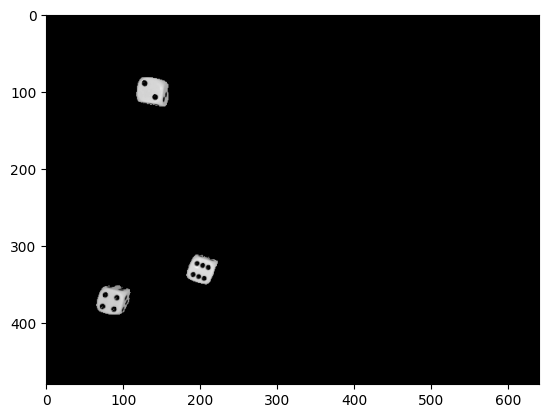

0.8444444444444444
1.1842105263157894
predicted dice: 4


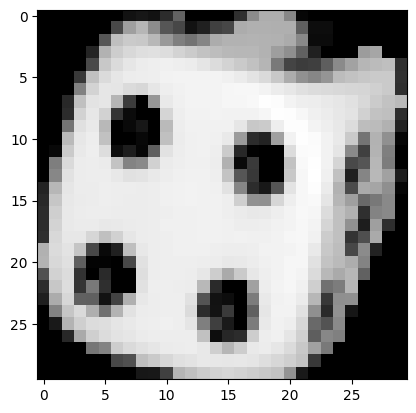

0.9512195121951219
1.0512820512820513
predicted dice: 6


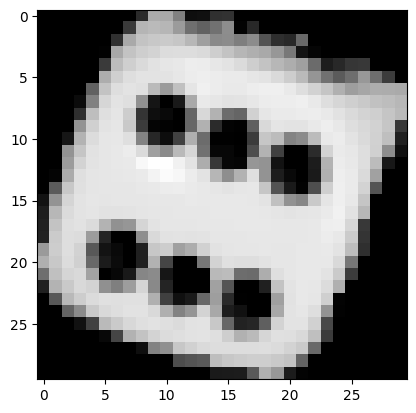

0.9047619047619048
1.105263157894737
predicted dice: 2


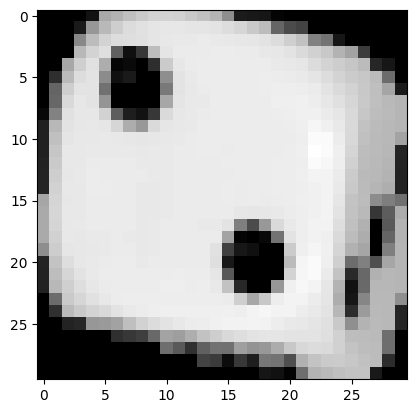

sum in image:  12


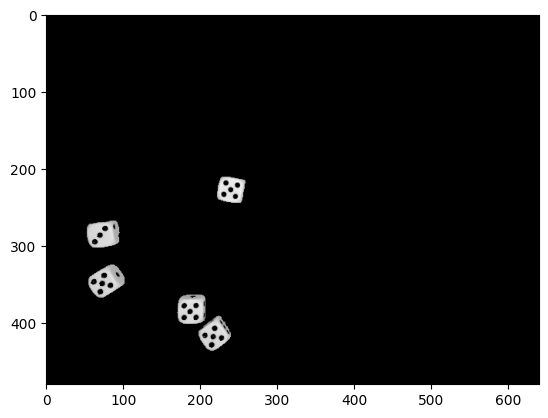

1.0952380952380953
0.9130434782608695
predicted dice: 5


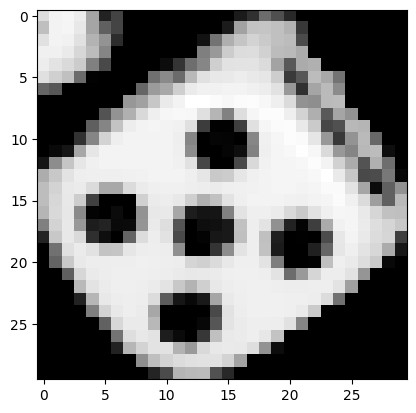

1.027027027027027
0.9736842105263158
predicted dice: 5


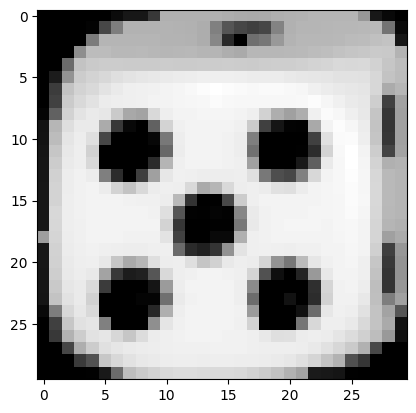

0.9148936170212766
1.0930232558139534
predicted dice: 5


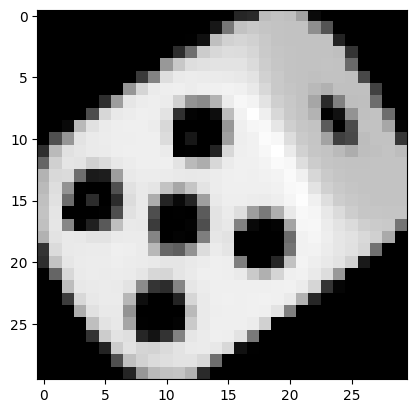

0.813953488372093
1.2285714285714286
predicted dice: 3


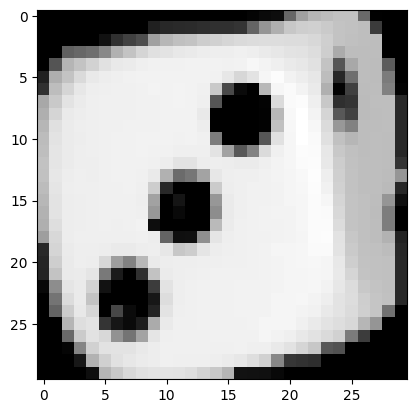

0.918918918918919
1.088235294117647
predicted dice: 5


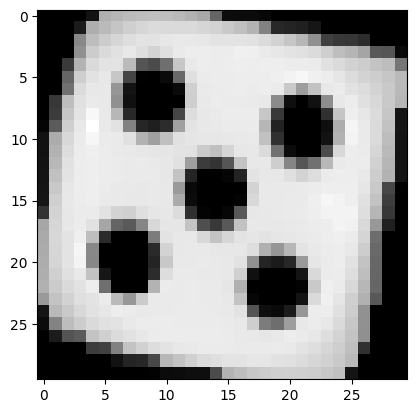

sum in image:  23


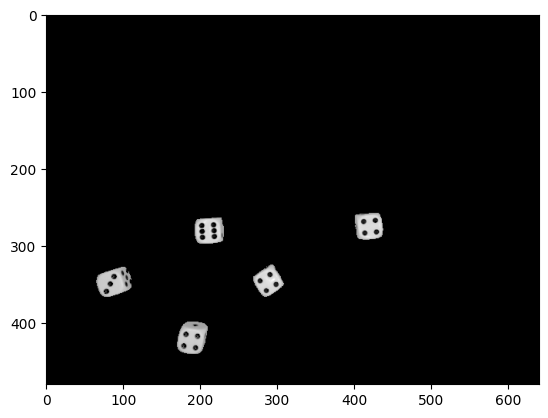

1.05
0.9523809523809523
predicted dice: 4


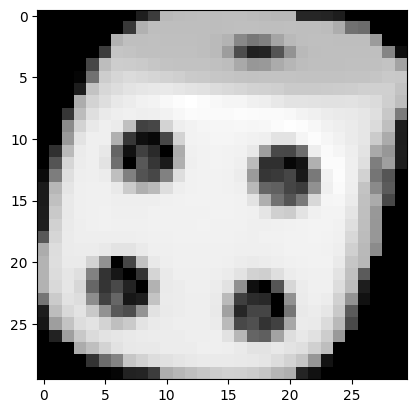

0.8478260869565217
1.1794871794871795
predicted dice: 3


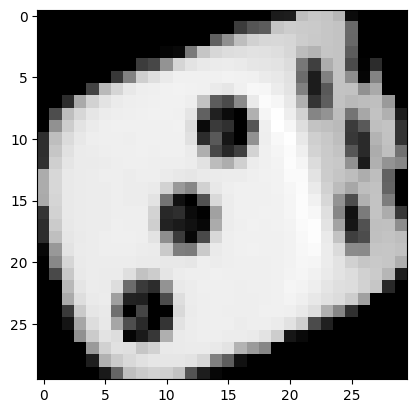

1.05
0.9523809523809523
predicted dice: 4


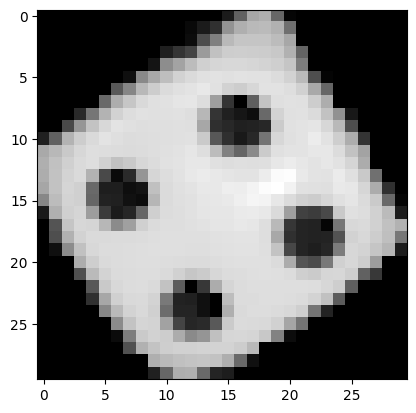

0.8947368421052632
1.1176470588235294
predicted dice: 6


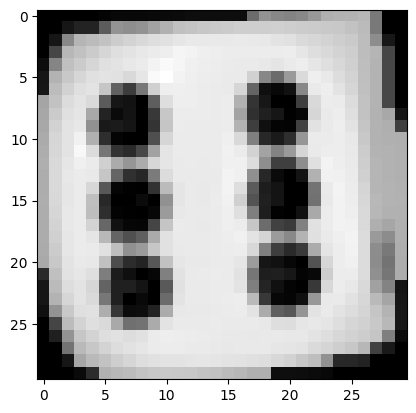

0.9459459459459459
1.0571428571428572
predicted dice: 4


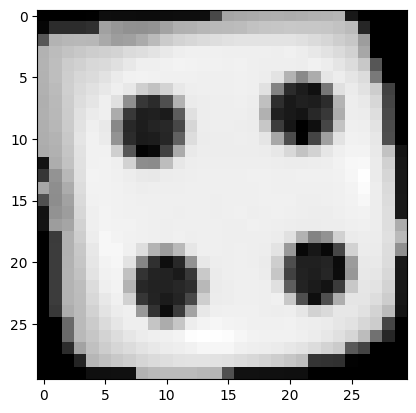

sum in image:  21


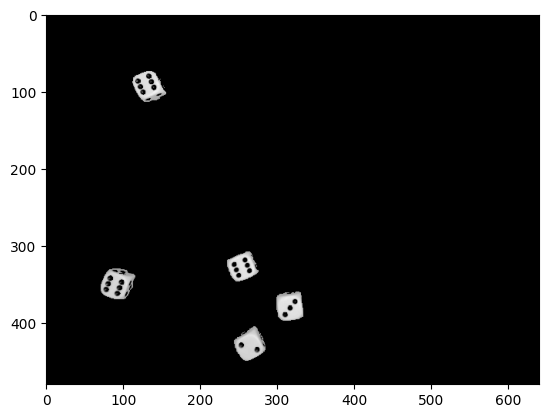

1.0975609756097562
0.9111111111111111
predicted dice: 2


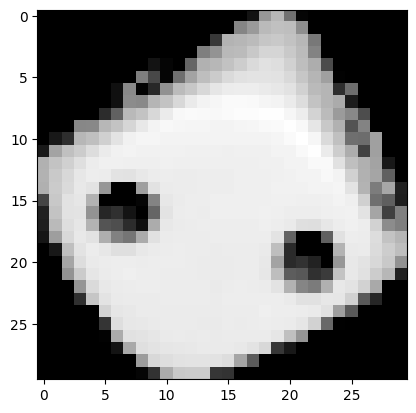

1.0857142857142856
0.9210526315789473
predicted dice: 3


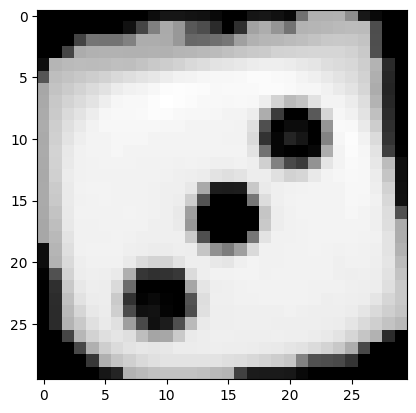

0.8888888888888888
1.125
predicted dice: 6


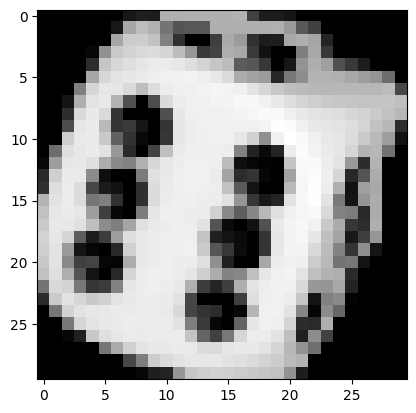

0.9512195121951219
1.0512820512820513
predicted dice: 6


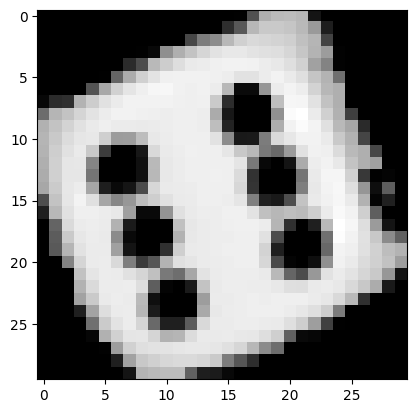

0.9090909090909091
1.1
predicted dice: 6


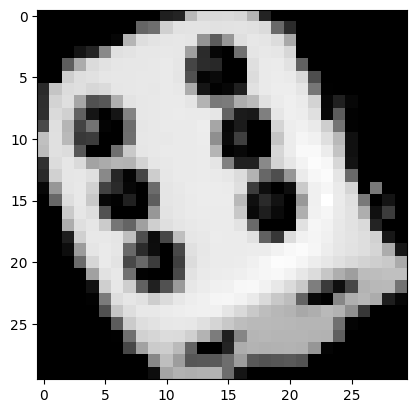

sum in image:  23


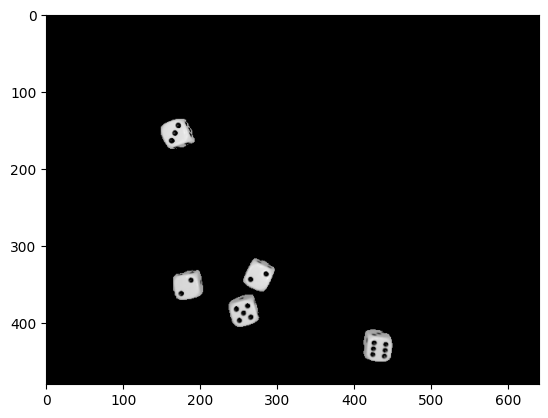

1.105263157894737
0.9047619047619048
predicted dice: 6


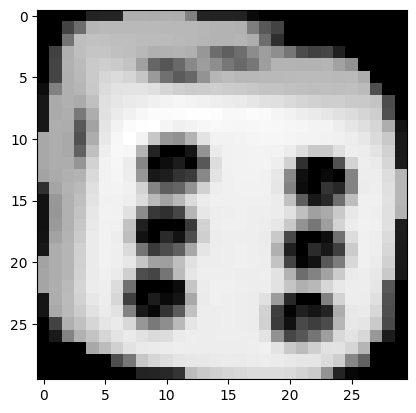

1.05
0.9523809523809523
predicted dice: 5


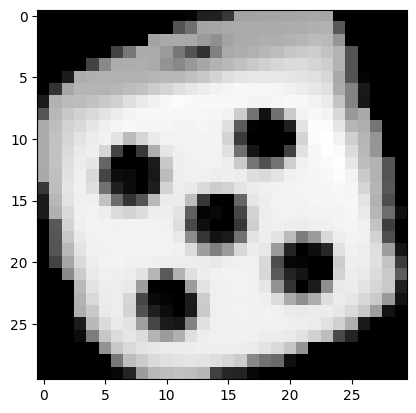

1.0
1.0
predicted dice: 2


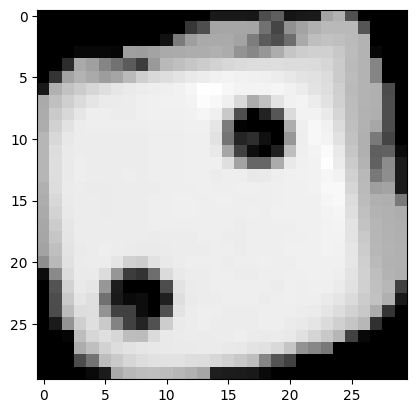

1.048780487804878
0.9534883720930233
predicted dice: 2


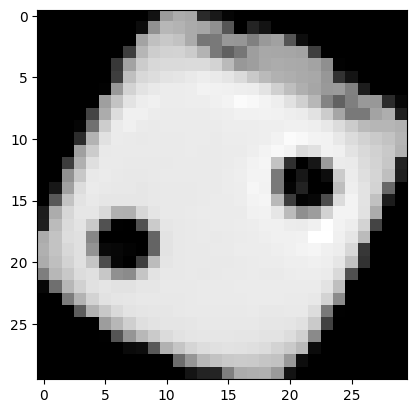

0.8863636363636364
1.1282051282051282
predicted dice: 3


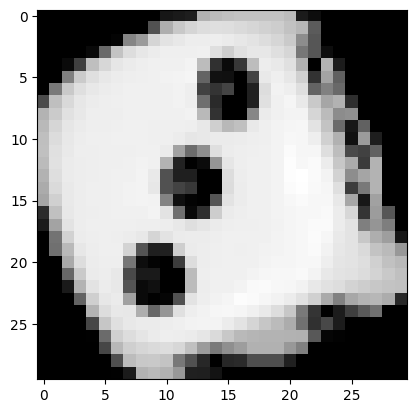

sum in image:  18


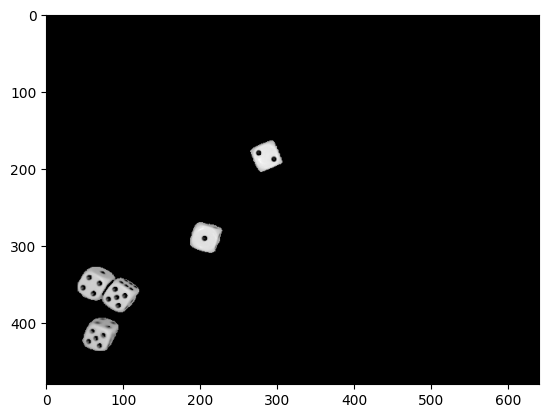

0.9148936170212766
1.0930232558139534
predicted dice: 5


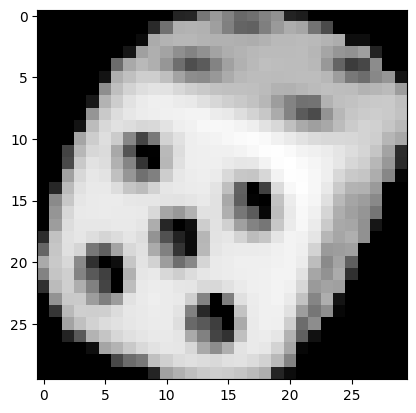

0.7375
1.3559322033898304
predicted dice: 5


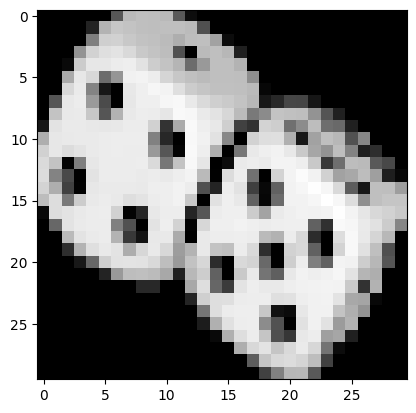

0.9523809523809523
1.05
predicted dice: 1


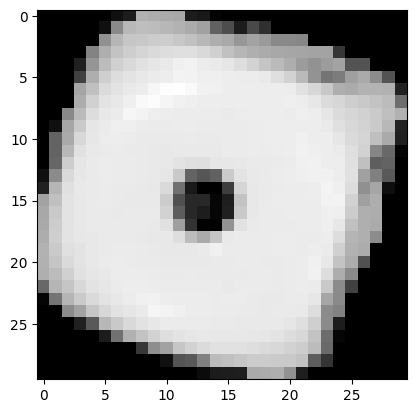

0.9761904761904762
1.024390243902439
predicted dice: 2


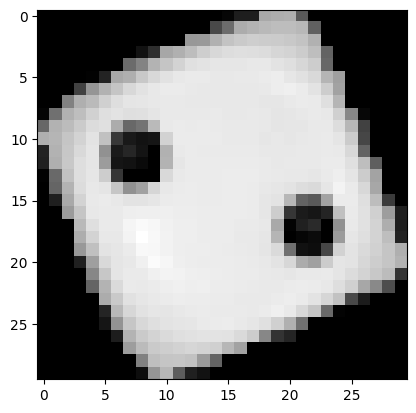

sum in image:  13


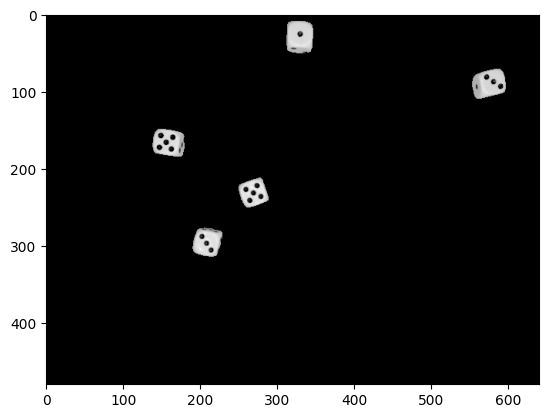

0.9743589743589743
1.0263157894736843
predicted dice: 3


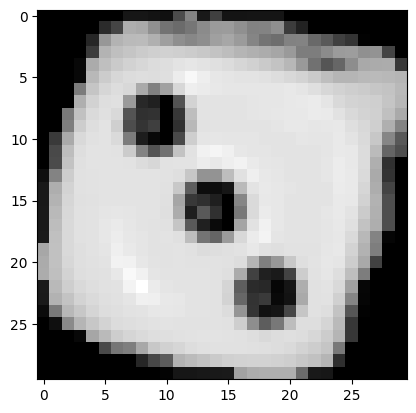

1.0
1.0
predicted dice: 5


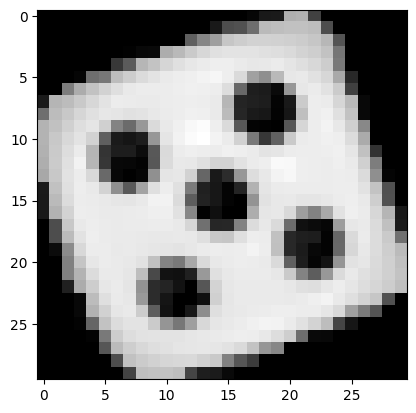

0.8571428571428571
1.1666666666666667
predicted dice: 5


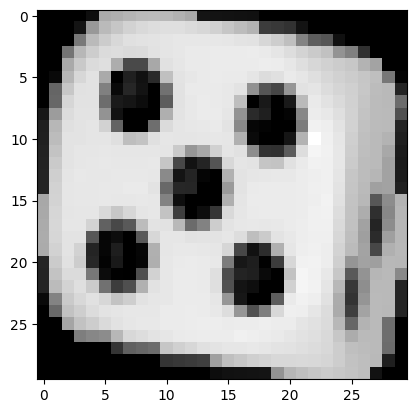

0.8863636363636364
1.1282051282051282
predicted dice: 3


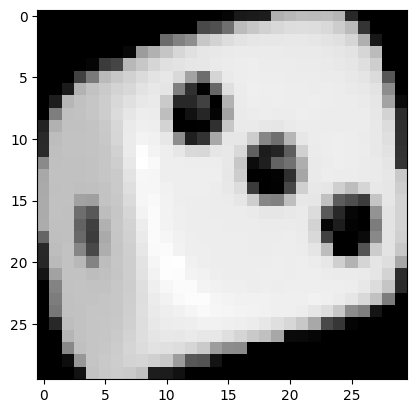

1.2
0.8333333333333334
predicted dice: 1


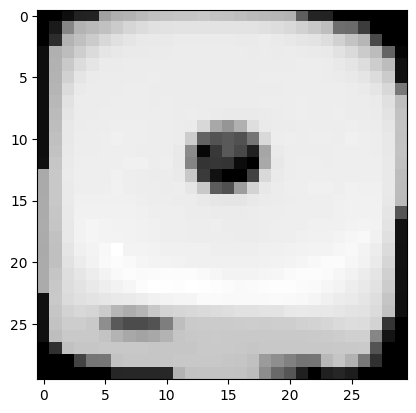

sum in image:  17


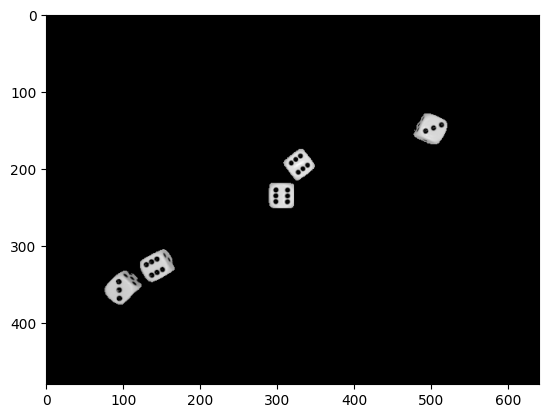

0.9166666666666666
1.0909090909090908
predicted dice: 3


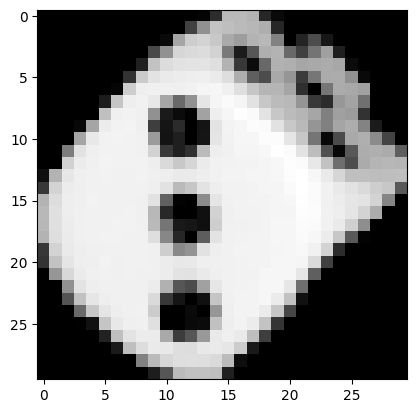

0.9555555555555556
1.0465116279069768
predicted dice: 6


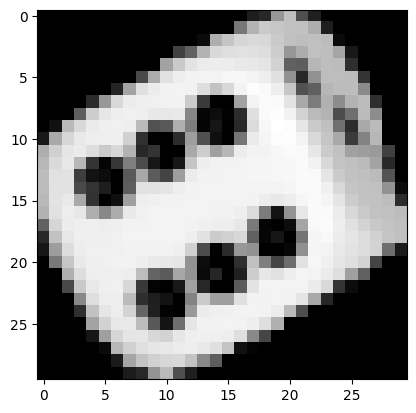

1.0
1.0
predicted dice: 6


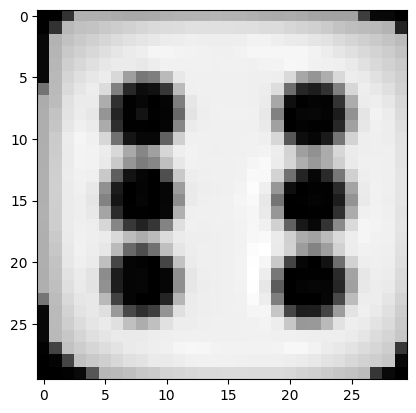

1.0
1.0
predicted dice: 6


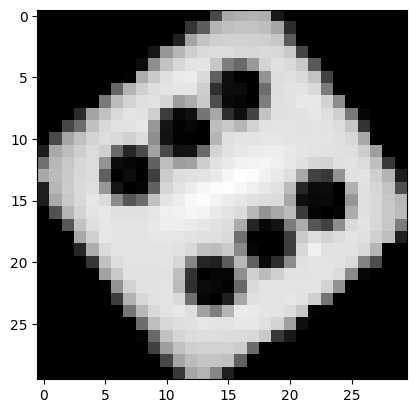

0.9090909090909091
1.1
predicted dice: 3


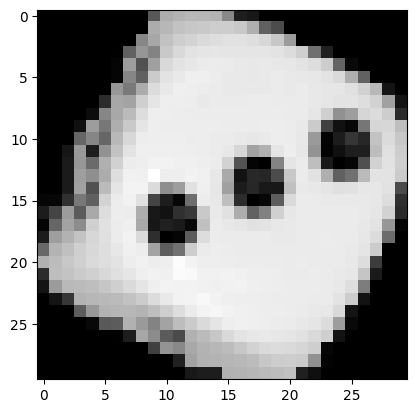

sum in image:  24


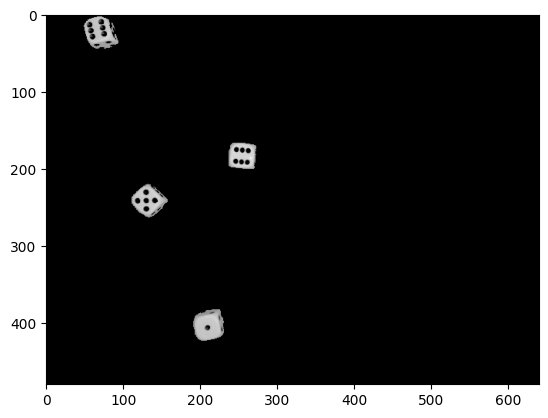

1.025
0.975609756097561
predicted dice: 1


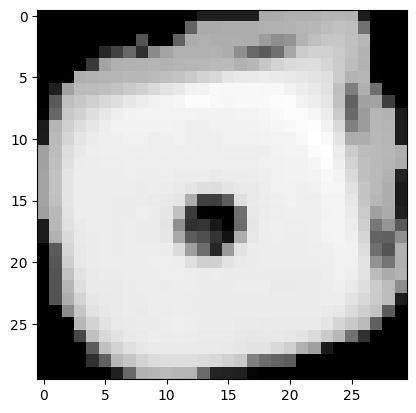

0.9361702127659575
1.0681818181818181
predicted dice: 5


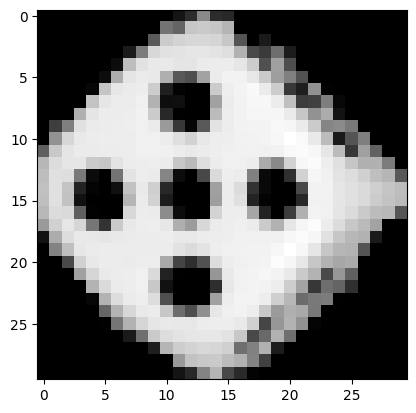

0.9444444444444444
1.0588235294117647
predicted dice: 6


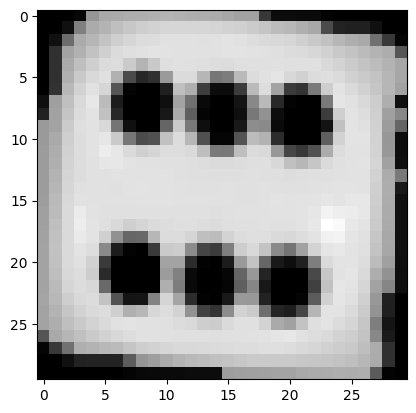

0.9333333333333333
1.0714285714285714
predicted dice: 6


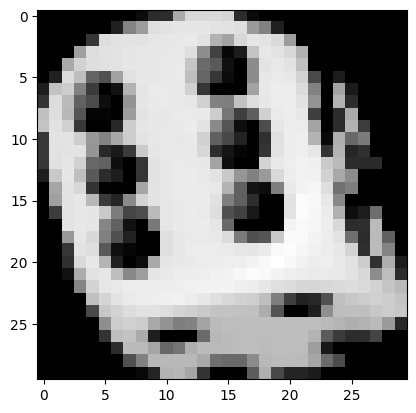

sum in image:  18


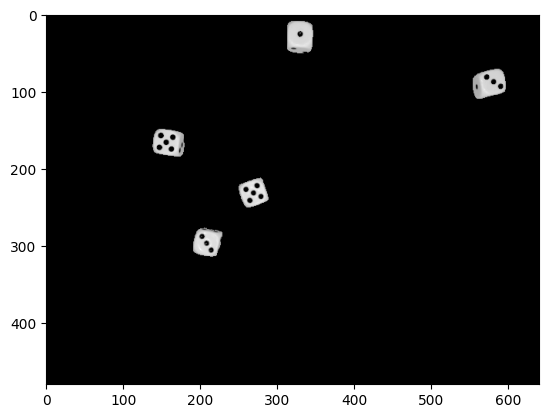

1.0
1.0
predicted dice: 3


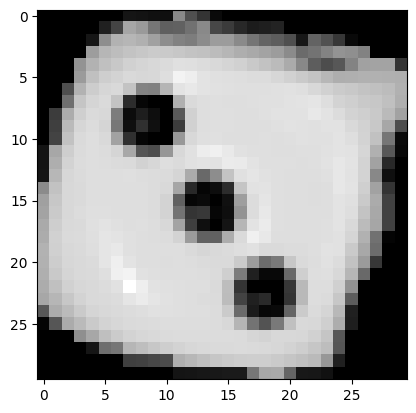

1.0
1.0
predicted dice: 5


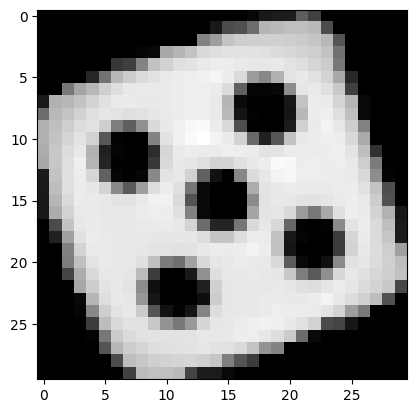

0.8571428571428571
1.1666666666666667
predicted dice: 5


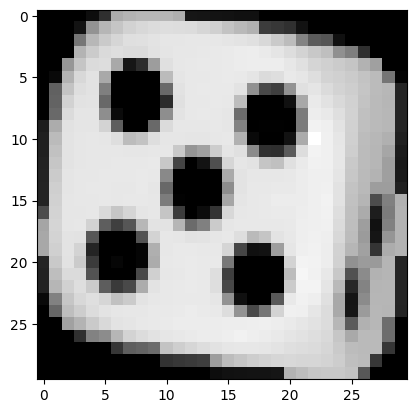

0.9069767441860465
1.1025641025641026
predicted dice: 3


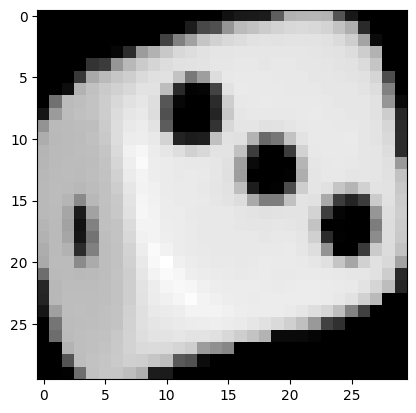

1.2352941176470589
0.8095238095238095
predicted dice: 1


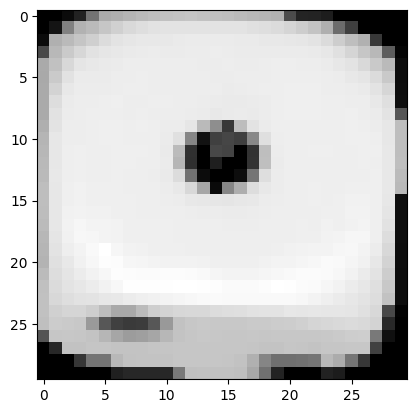

sum in image:  17


In [3]:
import matplotlib.pyplot as plt
import os

path = "/home/bule/projects/Dice/workspace/data/eyes2/still"
images = []

class_labels_dice = ["1", "2", "3", "4", "5", "6"]

for filename in os.listdir(path):
    img = cv2.imread(os.path.join(path, filename))
    if img is not None:
        images.append(img)

file_name_counter=0       
for img in images[:10]:
    img,dicecount, cropped_images = process_image(img)
    
    plt.imshow(img, cmap='gray')
    plt.show()
    
    sum_in_image=0
    for i in range(len(cropped_images)):
        
        print(cropped_images[i].shape[0] / cropped_images[i].shape[1])
        print(cropped_images[i].shape[1] / cropped_images[i].shape[0])
        
        frame = cv2.resize(cropped_images[i], (30, 30))
        
        output_data_dice = predict_dice(frame)
        prediction_dice = np.argmax(output_data_dice)
        dice_label = class_labels_dice[prediction_dice]
        print(f'predicted dice: {dice_label}')
        sum_in_image+=int(dice_label)
        
        
        
        ## save the images
        #cv2.imwrite('/home/bule/projects/Dice/data/single_dices/dice{}.png'.format(file_name_counter), frame)
        file_name_counter+=1
        plt.imshow(frame, cmap='gray')
        plt.show()
        
    print('sum in image: ', sum_in_image) 
        
    
        
        

In [ ]:
### all togehter export to rasperry pi

import tflite_runtime.interpreter as tflite
import cv2
import numpy as np

## laod model
interpreter_dice = tflite.Interpreter(model_path="/home/bule/projects/Dice/models/model_single_dices.tflite")
interpreter_dice.allocate_tensors()
input_details_dice= interpreter_dice.get_input_details()
output_details_dice = interpreter_dice.get_output_details()
input_shape_dice = input_details_dice[0]['shape']


# predict 30 X30 image if in 1-6 

def predict_dice(frame):
    # Convert frame to grayscale if not already done
    if len(frame.shape) > 2 and frame.shape[2] == 3:
        frame = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Resize the image to match the input shape expected by the model
    frame = cv2.resize(frame, (input_shape_dice[1], input_shape_dice[2]))

    # Convert the image to float32
    frame = frame.astype(np.float32)
    
    # Normalize the image if required (check your model's training code)
    frame /= 255.0

    # Add a channels dimension
    frame = np.expand_dims(frame, axis=-1)

    # Expand dimensions to represent batch size
    input_data = np.expand_dims(frame, axis=0)
    
    # Set the input tensor
    interpreter_dice.set_tensor(input_details_dice[0]['index'], input_data)
    
    # Run inference
    interpreter_dice.invoke()
    
    # Get the output tensor
    output_data_dice = interpreter_dice.get_tensor(output_details_dice[0]['index'])
    return output_data_dice


def process_image(img):
    # Convert the image to HSV color space
    hsv_image = cv2.cvtColor(img, cv2.COLOR_RGB2HSV)

    # Define the lower and upper bounds for the green color
    lower_bound = np.array([0, 80, 0])
    upper_bound = np.array([170, 255, 255])

    # Create a mask of the green background
    bg_mask = cv2.inRange(hsv_image, lower_bound, upper_bound)

    # Invert the mask to get the mask of the objects
    objects_mask = cv2.bitwise_not(bg_mask)

    # Remove the background from the objects image
    objects_no_bg = cv2.bitwise_and(img, img, mask=objects_mask)

    # Convert the objects image with no background to grayscale
    objects_gray = cv2.cvtColor(objects_no_bg, cv2.COLOR_RGB2GRAY)

    # Connected components to filter out small areas
    num_labels, labels, stats, _ = cv2.connectedComponentsWithStats(objects_gray, connectivity=8)

    # Create an output image initialized to zero
    output_image = np.zeros_like(objects_gray)


    dicecount=0
    # Filter out small components based on a size threshold
    for i in range(1, num_labels):  # Start from 1 to ignore the background component
        if stats[i, cv2.CC_STAT_AREA] >= 80:
            output_image[labels == i] = 255
            dicecount+=1

    # Create a binary mask from the output image
    binary_mask = np.uint8(output_image > 0)

    # Find contours in the binary mask
    contours, _ = cv2.findContours(binary_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Create an empty mask for the convex hulls
    hull_mask = np.zeros_like(binary_mask)

    cropped_images = []
    # Draw the convex hulls of the contours on the mask
    for contour in contours:
        hull = cv2.convexHull(contour)
        x, y, w, h = cv2.boundingRect(hull)
        # Crop the original image using the bounding rectangle coordinates
        cropped_image = objects_gray[y:y+h, x:x+w]
        cropped_images.append(cropped_image)
        cv2.drawContours(hull_mask, [hull], -1, (255), thickness=cv2.FILLED)

    # Apply the convex hull mask to the grayscale objects image
    objects_gray[hull_mask == 0] = 0

    return objects_gray,dicecount,cropped_images


def get_sum_in_image(img):
    class_labels_dice = ["1", "2", "3", "4", "5", "6"]
    img,_, cropped_images = process_image(img)

    sum_in_image=0
    for i in range(len(cropped_images)):
        frame = cv2.resize(cropped_images[i], (30, 30))
        
        output_data_dice = predict_dice(frame)
        prediction_dice = np.argmax(output_data_dice)
        dice_label = class_labels_dice[prediction_dice]
        sum_in_image+=int(dice_label)
    return sum_in_image    